### **Imports and Configurations:**

In [1]:
import warnings
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

from scripts.utils import multiline_print

# Constants
from scripts.configs import DIS_CMAP

In [2]:
warnings.filterwarnings('ignore')

### **Loading Data:**

In [3]:
credits_df = pd.read_csv("./data/tmdb_5000_credits.csv")
info_df = pd.read_csv("./data/tmdb_5000_movies.csv")

#### Combining Dataframes:
**NOTE:** First, we have to check if given IDs are indeed unique before merging the two dataframes to avoid conflicts

In [4]:
# Checking whether id columns are unique
print(f"Credits Shape: {list(credits_df.shape)}")
print(f"Info Shape: {list(info_df.shape)}", end="\n\n")


print(f"All IDs in the credits dataframe are unique: {credits_df['movie_id'].nunique() == len(credits_df)}")
print(f"All IDs in the info dataframe are unique: {info_df['id'].nunique() == len(info_df)}", end='\n\n')

# Merging dataframes
movies_df = credits_df.merge(info_df, left_on='movie_id', right_on='id', how='outer').drop(columns=['id', 'title_y', 'original_title',
                                                                                                    'homepage', 'overview', 'production_countries',
                                                                                                    'spoken_languages', 'tagline', 'crew'])
movies_df.rename(columns={'title_x': 'title',
                          }, inplace=True)
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

movies_df.head()

Credits Shape: [4803, 4]
Info Shape: [4803, 20]

All IDs in the credits dataframe are unique: True
All IDs in the info dataframe are unique: True



,movie_id,title,cast,budget,genres,keywords,original_language,popularity,production_companies,release_date,revenue,runtime,status,vote_average,vote_count
0,5,Four Rooms,"[{""cast_id"": 42, ""character"": ""Ted the Bellhop...",4000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 35, ""name...","[{""id"": 612, ""name"": ""hotel""}, {""id"": 613, ""na...",en,22.876230,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",1995-12-09,4300000,98.0,Released,6.5,530
1,11,Star Wars,"[{""cast_id"": 3, ""character"": ""Luke Skywalker"",...",11000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...","[{""id"": 803, ""name"": ""android""}, {""id"": 4270, ...",en,126.393695,"[{""name"": ""Lucasfilm"", ""id"": 1}, {""name"": ""Twe...",1977-05-25,775398007,121.0,Released,8.1,6624
2,12,Finding Nemo,"[{""cast_id"": 8, ""character"": ""Marlin (voice)"",...",94000000,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...","[{""id"": 494, ""name"": ""father son relationship""...",en,85.688789,"[{""name"": ""Pixar Animation Studios"", ""id"": 3}]",2003-05-30,940335536,100.0,Released,7.6,6122
3,13,Forrest Gump,"[{""cast_id"": 7, ""character"": ""Forrest Gump"", ""...",55000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...","[{""id"": 422, ""name"": ""vietnam veteran""}, {""id""...",en,138.133331,"[{""name"": ""Paramount Pictures"", ""id"": 4}]",1994-07-06,677945399,142.0,Released,8.2,7927
4,14,American Beauty,"[{""cast_id"": 6, ""character"": ""Lester Burnham"",...",15000000,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 255, ""name"": ""male nudity""}, {""id"": 29...",en,80.878605,"[{""name"": ""DreamWorks SKG"", ""id"": 27}, {""name""...",1999-09-15,356296601,122.0,Released,7.9,3313


### **Exploring the data:**

In [5]:
print("Data Columns:")
multiline_print(movies_df.columns)
print(f"Data Shape: {movies_df.shape}", end="\n\n")
print(f"NaN Counts:\n{movies_df.isna().sum()}", end="\n\n")
print(f"Unique Value Counts:\n{movies_df.nunique()}", end="\n\n")
print(f"Dataset Description:\n{movies_df.describe()}", end="\n\n")

Data Columns:
| movie_id | title | cast | budget | genres |
| keywords | original_language | popularity | production_companies | release_date |
| revenue | runtime | status | vote_average | vote_count |

Data Shape: (4803, 15)

NaN Counts:
movie_id                0
title                   0
cast                    0
budget                  0
genres                  0
keywords                0
original_language       0
popularity              0
production_companies    0
release_date            1
revenue                 0
runtime                 2
status                  0
vote_average            0
vote_count              0
dtype: int64

Unique Value Counts:
movie_id                4803
title                   4800
cast                    4761
budget                   436
genres                  1175
keywords                4222
original_language         37
popularity              4802
production_companies    3697
release_date            3280
revenue                 3297
runtime         

### **Cleaning Numerical Columns:**

#### Managing Wrong Values:
Although columns like `budget` and `revenue` can be zero, it doesn't make sense for the `runtime` column to be zero. movies with zero runtime are removed from the dataset!

In [6]:
zero_count = (movies_df['runtime'] == 0).sum()
print(f"Number of movies with zero runtime: {zero_count}")

# Set to nan
movies_df.loc[movies_df['runtime'] == 0, 'runtime'] = np.nan

Number of movies with zero runtime: 35


#### Managing Missing Values:
The runtime column has some nan values which can be imputed statistically usnig the mean.

The rest of missing values are minimal and can be removed from dataset without any compromise.

In [7]:
movies_df['runtime'].fillna(movies_df['runtime'].mean(), inplace=True)

movies_df = movies_df.dropna()

#### Managing Outliers:
We use a z-score of 3.5 as the outlier threshold. 

In [8]:
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
z_scores = np.abs(zscore(movies_df[numeric_cols]))
mask = (z_scores < 3.5).all(axis=1)
new_movies_df = movies_df[mask]

print(f"Numeric Columns: {list(numeric_cols)}", end="\n\n")
print(f"New Data Shape: {new_movies_df.shape}", end="\n\n")
print(f"Number of Detected Outliers: {len(movies_df) - len(new_movies_df)}")

Numeric Columns: ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

New Data Shape: (4522, 15)

Number of Detected Outliers: 280


#### **Plotting Changes After Removing Outliers:** 
This is a histogram of each column before and after removing outliers:

Column 'budget' Skewness with outliers: 2.4369746818509563
                        without outliers: 1.8290731570081105
Column 'popularity' Skewness with outliers: 9.721432468473274
                        without outliers: 1.7104882833840747
Column 'revenue' Skewness with outliers: 4.444319478473696
                        without outliers: 2.516990775465676
Column 'runtime' Skewness with outliers: 1.8308506020263473
                        without outliers: 0.9139732439620158
Column 'vote_average' Skewness with outliers: 1.9508782261268534
                        without outliers: 0.5975696591783486
Column 'vote_count' Skewness with outliers: 3.8237311099075906
                        without outliers: 2.569083366937555


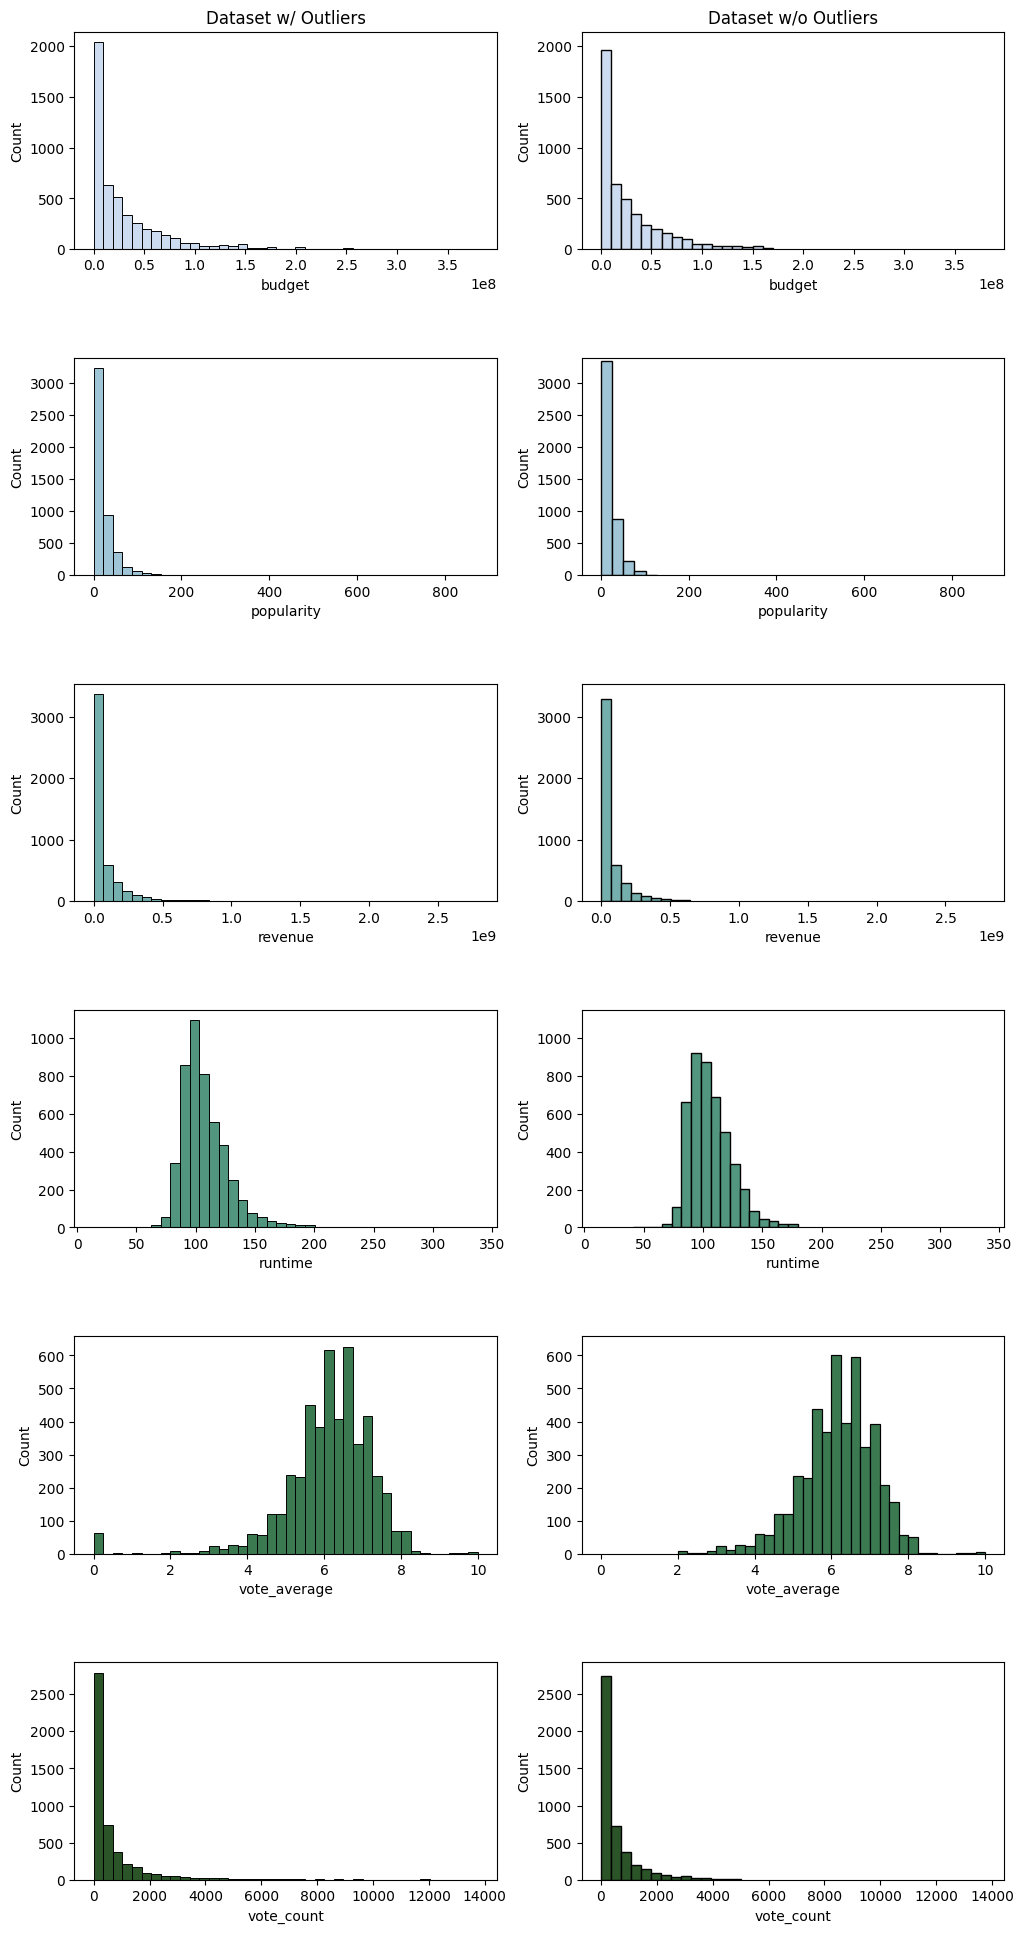

In [28]:
numeric_cols = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
fig, axes = plt.subplots(6,2, figsize=(12,24))
plt.subplots_adjust(hspace=.5)
axes[0, 0].set_title('Dataset w/ Outliers')
axes[0, 1].set_title('Dataset w/o Outliers')
for idx, col in enumerate(numeric_cols):
    print(f"Column '{col}' Skewness with outliers: {abs(movies_df[col].skew())}")
    print(f"                        without outliers: {abs(new_movies_df[col].skew())}")

    col_range = np.ptp(movies_df[col])
    new_col_range = np.ptp(new_movies_df[col])
    bin_width = col_range / 40
    new_num_bins = int(new_col_range // bin_width)

    Lplot = sns.histplot(data=movies_df, x=col, ax=axes[idx, 0], bins=40)
    Rplot = sns.histplot(data=new_movies_df, x=col, ax=axes[idx, 1], bins=new_num_bins)

    for bin_ in Lplot.patches:
        bin_.set_facecolor(DIS_CMAP(7)[idx])
    for bin_ in Rplot.patches:
        bin_.set_facecolor(DIS_CMAP(7)[idx])

    xlim = axes[idx, 0].get_xlim()
    ylim = axes[idx, 0].get_ylim()
    axes[idx, 1].set_xlim(xlim)
    axes[idx, 1].set_ylim(ylim)

### **Cleaning Non-numerical Columns:**

#### Loading Json Dictionaries:

In [10]:
json_columns = ['cast', 'genres', 'keywords', 'production_companies']
for column in json_columns:
    new_movies_df[column] = new_movies_df[column].apply(json.loads)

#### Adding Actors as Feature:
In this step, we create a separate dataframe for the cast of each movie. 

In [11]:
# Creating a Casts Dataframe
cast_df = new_movies_df[['movie_id', 'revenue','cast']]
cast_df = cast_df.explode('cast').reset_index(drop=True)


'Number of movies with less than 5 cast: ' +  str((cast_df.groupby('movie_id').count() < 5)['cast'].sum()), \
'Number of movies with less than 3 cast: ' +  str((cast_df.groupby('movie_id').count() < 3)['cast'].sum())

('Number of movies with less than 5 cast: 139',
 'Number of movies with less than 3 cast: 43')

In [12]:
# Removing excess information about the cast
cast_df['cast_id'] = cast_df['cast'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
cast_df['cast_name'] = cast_df['cast'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
cast_df['order'] = cast_df['cast'].apply(lambda x: x.get('order') if isinstance(x, dict) else None)

print(f"NaN Counts (REMOVED):\n{cast_df.isna().sum()}")

new_cast_df = cast_df.drop(columns=['cast', 'revenue']).dropna()
cast_df['cast_id'] = cast_df['cast_id']
new_cast_df

NaN Counts (REMOVED):
movie_id      0
revenue       0
cast         24
cast_id      24
cast_name    24
order        24
dtype: int64


,movie_id,cast_id,cast_name,order
0,5,3129.0,Tim Roth,0.0
1,5,3131.0,Antonio Banderas,1.0
2,5,3130.0,Jennifer Beals,2.0
3,5,3125.0,Madonna,3.0
4,5,3141.0,Marisa Tomei,4.0
...,...,...,...,...
95608,426469,1505855.0,Paul Castro Jr.,18.0
95609,426469,1744340.0,Edward Prostak,19.0
95610,426469,1506479.0,Deema Aitken,20.0
95611,426469,1085656.0,Laurie Dawn,21.0


**NOTE:** Since the number of movies with less than 5 cast members is insignificant, we will have the top 5 members of the cast in our analytical process.

#### Choosing top 5 cast members to include in the data:
For this purpose, we can either rank actors by the average of revenues of their movies or by the provided order in tmdb.

First we examine the first method:

In [13]:
cast_rankings = cast_df[['cast_id', 'revenue']].groupby('cast_id').mean('revenue')
cast_rankings = cast_rankings.sort_values(by='revenue', ascending=False).reset_index()
cast_rankings

,cast_id,revenue
0,51671.0,649398328.0
1,1427911.0,649398328.0
2,75742.0,649398328.0
3,33187.0,649398328.0
4,33188.0,649398328.0
...,...,...
50264,4619.0,0.0
50265,1375084.0,0.0
50266,101023.0,0.0
50267,1375162.0,0.0


As it can be seen, this method puts too much of a high value on side characters of super successful movies, which is not convenient.

Therefore, we will use the provided order.

**NOTE:** Since the dataframe is not clean and orders don't necessarily contain 0 through 4, we have to extract the minimum manually 5 times.

In [14]:
top_casts_df = new_cast_df.where(new_cast_df['order'] <= 4.0).dropna()
cast_movie_df = new_movies_df

for idx in range(5):
    top_idx = top_casts_df.groupby('movie_id')['order'].idxmin()
    top = top_casts_df.loc[top_idx]
    cast_movie_df = pd.merge(cast_movie_df, top, on='movie_id', how='left').drop(columns=['cast_id', 'order']).rename(columns={'cast_name': f"actor_name_{idx+1}"})
    top_casts_df = top_casts_df[~top_casts_df.isin(top)].dropna()

cast_movie_df.fillna('#John Doe#', inplace=True)
cast_movie_df.drop(columns=['cast'], inplace=True)

**NOTE:** Missing actors fields are filled with a constant token ("`#John Doe#`")

#### Adding Production Companies as Feature:

In [15]:
cast_movie_df.iloc[0]['production_companies'][0]

{'name': 'Miramax Films', 'id': 14}

In [16]:
# Creating a Casts Dataframe
prod_df = cast_movie_df[['movie_id', 'production_companies']]
prod_df = prod_df.explode('production_companies').reset_index(drop=True)


'Number of movies with less than 1 cast: ' +  str((prod_df.groupby('movie_id').count() < 1)['production_companies'].sum()), \
'Number of movies with less than 2 cast: ' +  str((prod_df.groupby('movie_id').count() < 2)['production_companies'].sum())

('Number of movies with less than 1 cast: 307',
 'Number of movies with less than 2 cast: 1324')

In [17]:
# Removing excess information about the cast
prod_df['producer_id'] = prod_df['production_companies'].apply(lambda x: x.get('id') if isinstance(x, dict) else None)
prod_df['production_company_name'] = prod_df['production_companies'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)

print(f"NaN Counts (REMOVED):\n{prod_df.isna().sum()}")

new_prod_df = prod_df.drop(columns=['production_companies']).dropna()
prod_df['producer_id'] = prod_df['producer_id']
new_prod_df

NaN Counts (REMOVED):
movie_id                     0
production_companies       307
producer_id                307
production_company_name    307
dtype: int64


,movie_id,producer_id,production_company_name
0,5,14.0,Miramax Films
1,5,59.0,A Band Apart
2,14,27.0,DreamWorks SKG
3,14,2721.0,Jinks/Cohen Company
4,16,8.0,Fine Line Features
...,...,...,...
13227,389425,35625.0,Premiere Entertainment Group
13228,394047,37081.0,ESX Productions
13229,394047,79279.0,ESX Entertainment
13231,407887,3965.0,Taewon Entertainment


In [18]:
prod_movie_df = cast_movie_df

top = new_prod_df.groupby('movie_id').first()
prod_movie_df = pd.merge(prod_movie_df, top, on='movie_id', how='left').drop(columns=['producer_id'])
prod_movie_df = prod_movie_df[~prod_movie_df.isin(top)]

prod_movie_df.fillna('#Jane Doe Inc#', inplace=True)
prod_movie_df.drop(columns=['production_companies'], inplace=True)

**NOTE:** Missing values in production company is filled with a constant token ("`#Jane Doe Inc#`")

#### Adding Genres as Feature:

First, we extract all the genres and a dataframe containing movie-genre pairs

In [19]:
genre_df = prod_movie_df[['movie_id','genres']]
genre_df = genre_df.explode('genres').reset_index(drop=True)

genre_df['name'] = genre_df['genres'].apply(lambda x: x.get('name') if isinstance(x, dict) else None)
genre_df = genre_df.drop(columns=['genres']).dropna().rename(columns={'name': 'genre'})
genres = genre_df['genre'].unique().tolist()
multiline_print(genres)
genre_df

| Crime | Comedy | Drama | Music | Adventure |
| Fantasy | Action | Thriller | Science Fiction | Romance |
| War | Western | Animation | Family | Mystery |
| History | Horror | Documentary | Foreign | TV Movie |



,movie_id,genre
0,5,Crime
1,5,Comedy
2,14,Drama
3,16,Drama
4,16,Crime
...,...,...
11432,417859,Family
11433,417859,Fantasy
11434,426469,Comedy
11435,426469,Family


In [20]:
one_hot = pd.get_dummies(genre_df.set_index('movie_id')['genre'])
one_hot = one_hot.groupby('movie_id').max()
final_movies_df = prod_movie_df.merge(one_hot, on='movie_id', how='left').drop(columns=['genres'])
final_movies_df.fillna(False, inplace=True)

### **Final Cleaning Tasks:**
We remove the ID column since the default index can be used as a unique ID.

We add a numerical column for each of the categorical columns in the data (`status`, `language`, actors, and production company).

We also Split the release date into three separate columns.

Next, we add a column `binned_revenue`, binning the revenues into 30 equal bins.

Finally, we add a profit_rate to the dataset. (This ratio is capped at 100x)

In [21]:
final_movies_df.drop(columns=['movie_id'], inplace=True)

final_movies_df['original_language'] = final_movies_df['original_language'].astype('category')
final_movies_df['status'] = final_movies_df['status'].astype('category')
final_movies_df['actor_name_1'] = final_movies_df['actor_name_1'].astype('category')
final_movies_df['actor_name_2'] = final_movies_df['actor_name_2'].astype('category')
final_movies_df['actor_name_3'] = final_movies_df['actor_name_3'].astype('category')
final_movies_df['actor_name_4'] = final_movies_df['actor_name_4'].astype('category')
final_movies_df['actor_name_5'] = final_movies_df['actor_name_5'].astype('category')
final_movies_df['production_company_name'] = final_movies_df['production_company_name'].astype('category')

final_movies_df['language_code'] = final_movies_df['original_language'].cat.codes
final_movies_df['status_code'] = final_movies_df['status'].cat.codes
final_movies_df['actor_1_code'] = final_movies_df['actor_name_1'].cat.codes
final_movies_df['actor_2_code'] = final_movies_df['actor_name_2'].cat.codes
final_movies_df['actor_3_code'] = final_movies_df['actor_name_3'].cat.codes
final_movies_df['actor_4_code'] = final_movies_df['actor_name_4'].cat.codes
final_movies_df['actor_5_code'] = final_movies_df['actor_name_5'].cat.codes
final_movies_df['production_company_code'] = final_movies_df['production_company_name'].cat.codes

final_movies_df['year'] = final_movies_df['release_date'].dt.year
final_movies_df['month'] = final_movies_df['release_date'].dt.month
final_movies_df['day'] = final_movies_df['release_date'].dt.day

final_movies_df['binned_revenue'] = pd.cut(final_movies_df['revenue'], bins=30, labels=False)

final_movies_df['profit_rate'] = final_movies_df['revenue'].astype('float') / final_movies_df['budget']
final_movies_df['profit_rate'] = final_movies_df['profit_rate'].fillna(0)
final_movies_df['profit_rate'] = final_movies_df['profit_rate'].replace(np.inf, np.nan)
final_movies_df['profit_rate'] = np.where(final_movies_df['profit_rate'] > 100, 100, final_movies_df['profit_rate'])

### **Saving Clean Dataset:**

In [22]:
final_movies_df.to_csv('./data/movies_data.csv')

### **The Final Dataset:**

In [23]:
multiline_print(final_movies_df.columns)

final_movies_df

| title | budget | keywords | original_language | popularity |
| release_date | revenue | runtime | status | vote_average |
| vote_count | actor_name_1 | actor_name_2 | actor_name_3 | actor_name_4 |
| actor_name_5 | production_company_name | Action | Adventure | Animation |
| Comedy | Crime | Documentary | Drama | Family |
| Fantasy | Foreign | History | Horror | Music |
| Mystery | Romance | Science Fiction | TV Movie | Thriller |
| War | Western | language_code | status_code | actor_1_code |
| actor_2_code | actor_3_code | actor_4_code | actor_5_code | production_company_code |
| year | month | day | binned_revenue | profit_rate |



,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,vote_average,...,actor_2_code,actor_3_code,actor_4_code,actor_5_code,production_company_code,year,month,day,binned_revenue,profit_rate
0,Four Rooms,4000000,"[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...",en,22.876230,1995-12-09,4300000,98.0,Released,6.5,...,164,1299,2006,1988,765,1995,12,9,0,1.075000
1,American Beauty,15000000,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...",en,80.878605,1999-09-15,356296601,122.0,Released,7.9,...,152,2749,3146,2092,341,1999,9,15,16,23.753107
2,Dancer in the Dark,12800000,"[{'id': 30, 'name': 'individual'}, {'id': 246,...",en,22.022228,2000-05-17,40031879,140.0,Released,7.6,...,364,661,2487,1504,430,2000,5,17,1,3.127491
3,The Fifth Element,90000000,"[{'id': 402, 'name': 'clone'}, {'id': 444, 'na...",en,109.528572,1997-05-07,263920180,126.0,Released,7.3,...,844,1122,2261,541,254,1997,5,7,12,2.932446
4,Metropolis,92620000,"[{'id': 312, 'name': 'man vs machine'}, {'id':...",de,32.351527,1927-01-10,650422,153.0,Released,8.0,...,70,1034,2715,1035,868,1927,1,10,0,0.007022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,Restoration,0,[],en,2.525569,2016-05-03,0,90.0,Released,5.3,...,25,2965,2771,0,0,2016,5,3,0,0.000000
4518,Operation Chromite,0,"[{'id': 10586, 'name': 'korea'}, {'id': 229851...",ko,6.116436,2016-07-27,0,110.0,Released,5.8,...,1538,1731,1507,1649,1098,2016,7,27,0,0.000000
4519,Perfect Cowboy,200,[],en,0.050978,2014-07-13,0,109.0,Released,5.0,...,1128,2925,2832,0,0,2014,7,13,0,0.000000
4520,Puss in Boots,130000000,"[{'id': 4414, 'name': 'adventure'}, {'id': 618...",en,20.678787,2011-10-28,554987477,90.0,Released,6.4,...,2210,2963,340,139,339,2011,10,28,25,4.269134


In [24]:
final_movies_df.describe()

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count,language_code,status_code,actor_1_code,actor_2_code,actor_3_code,actor_4_code,actor_5_code,production_company_code,year,month,day,binned_revenue,profit_rate
count,4.522000e+03,4522.000000,4522,4.522000e+03,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.00000,4522.000000,4522.000000,4522.000000,4522.000000,4522.00000,4522.000000,4377.000000
mean,2.499776e+07,18.445546,2002-10-30 12:56:02.759840768,6.134228e+07,106.192215,6.141066,534.604157,7.474790,1.000221,1009.878594,1289.288368,1471.272888,1572.62008,1450.303848,680.032729,2002.310261,6.777974,15.15502,2.518576,3.331040
min,0.000000e+00,0.000372,1925-11-05 00:00:00,0.000000e+00,41.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1925.000000,1.000000,1.00000,0.000000,0.000000
25%,8.017370e+05,4.758016,1999-04-29 00:00:00,0.000000e+00,94.000000,5.600000,54.000000,7.000000,1.000000,513.250000,631.000000,718.000000,740.25000,557.250000,309.000000,1999.000000,4.000000,8.00000,0.000000,0.000000
50%,1.390000e+07,12.532788,2005-08-05 00:00:00,1.751021e+07,103.000000,6.200000,221.000000,7.000000,1.000000,986.000000,1283.500000,1461.000000,1563.00000,1437.500000,751.500000,2005.000000,7.000000,15.00000,0.000000,1.095031
75%,3.500000e+07,26.194756,2010-10-28 18:00:00,8.216507e+07,116.000000,6.800000,660.750000,7.000000,1.000000,1516.000000,1958.750000,2220.750000,2401.75000,2319.750000,1077.000000,2010.000000,10.000000,22.00000,3.000000,3.097505
max,1.700000e+08,127.525581,2017-02-03 00:00:00,6.493983e+08,180.000000,10.000000,4997.000000,35.000000,2.000000,2021.000000,2623.000000,2981.000000,3229.00000,3201.000000,1272.000000,2017.000000,12.000000,31.00000,29.000000,100.000000
std,3.164184e+07,18.614180,NaN,9.864183e+07,17.480076,0.952233,784.123341,3.027618,0.039348,583.530807,760.308668,865.707152,954.57838,991.544148,407.396524,12.312273,3.438179,8.64524,4.459033,9.608633
